# Prediction Training

In [1]:
import pandas as pd
import datetime as td
import  numpy as np
import datetime 
import datetime as dt
import numpy as np
import sys


In [37]:
forecast = pd.read_csv('forecastData/PPForecast.csv')
forecast=forecast.drop(['windGust'],1)
forecast

/tmp/ipykernel_461885/430475457.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  foorecast=forecast.drop(['windGust'],1)


,date,temperature,windDirection,windSpeed,windGust,humidity,pressure\n
0,2022-07-12T21:00:00Z,17.3,273.4,3.8,7.2,76.3,1021.9
1,2022-07-12T20:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-07-12T22:00:00Z,16.7,311.9,4.8,7.6,74.1,1022.6
3,2022-07-12T21:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-12T23:00:00Z,14.5,316.7,4.9,8.3,66.5,1023.9
...,...,...,...,...,...,...,...
227,2022-07-21T18:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN
228,2022-07-22T06:00:00Z,14.9,222.1,2.5,NaN,81.0,1016.0
229,2022-07-22T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN
230,2022-07-22T12:00:00Z,18.2,225.6,5.9,NaN,72.9,1013.8


In [44]:
forecast = pd.read_csv('forecastData/PPForecast.csv')
forecast=forecast.drop(['windGust'],1)
forecast= forecast.dropna()
forecast.columns=['date','dub_temp','dub_wddir','dub_wdsp','dub_hum','dub_press']
forecast=forecast._convert(numeric=True)

/tmp/ipykernel_461885/528228417.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast=forecast.drop(['windGust'],1)


In [56]:
forecast

,dub_temp,dub_wddir,dub_wdsp,date,dayInMonth,hour,dayOfWeek,dayOfYear,sin_hour,sin_day,cos_hour,cos_day
0,4.916641e+16,-5.667528e+18,-5.150559e+16,2022-07-12 21:00:00+00:00,12,21,1,193,-7.071068e-01,-0.179767,-7.071068e-01,-0.179767
2,4.746122e+16,-6.465626e+18,-6.505969e+16,2022-07-12 22:00:00+00:00,12,22,1,193,-5.000000e-01,-0.179767,-5.000000e-01,-0.179767
4,4.120884e+16,-6.565129e+18,-6.641510e+16,2022-07-12 23:00:00+00:00,12,23,1,193,-2.588190e-01,-0.179767,-2.588190e-01,-0.179767
6,3.694586e+16,-6.401364e+18,-4.743936e+16,2022-07-13 00:00:00+00:00,13,0,2,194,0.000000e+00,-0.196673,0.000000e+00,-0.196673
8,3.438807e+16,-5.930797e+18,-3.930690e+16,2022-07-13 01:00:00+00:00,13,1,2,194,2.588190e-01,-0.196673,2.588190e-01,-0.196673
10,3.183028e+16,-5.686185e+18,-4.337313e+16,2022-07-13 02:00:00+00:00,13,2,2,194,5.000000e-01,-0.196673,5.000000e-01,-0.196673
12,2.927249e+16,-5.321341e+18,-3.795149e+16,2022-07-13 03:00:00+00:00,13,3,2,194,7.071068e-01,-0.196673,7.071068e-01,-0.196673
14,2.841989e+16,-5.186597e+18,-3.524067e+16,2022-07-13 04:00:00+00:00,13,4,2,194,8.660254e-01,-0.196673,8.660254e-01,-0.196673
16,2.870409e+16,-5.346216e+18,-3.795149e+16,2022-07-13 05:00:00+00:00,13,5,2,194,9.659258e-01,-0.196673,9.659258e-01,-0.196673
18,3.097768e+16,-5.530712e+18,-4.472854e+16,2022-07-13 06:00:00+00:00,13,6,2,194,1.000000e+00,-0.196673,1.000000e+00,-0.196673


In [57]:
forecast = pd.read_csv('forecastData/PPForecast.csv')
forecast=forecast.drop(['windGust'],1)
forecast= forecast.dropna()
forecast.columns=['date','dub_temp','dub_wddir','dub_wdsp','dub_hum','dub_press']
forecast=forecast._convert(numeric=True)


#Just taking the columns used in prediction
finalCols= ['date','dub_temp','dub_wddir','dub_wdsp']
forecast = forecast[finalCols]

train_mean = np.loadtxt("./models/train_meanSave.csv",delimiter=',')
train_std = np.loadtxt("./models/train_stdSave.csv",delimiter=',')



forecast['date']=pd.to_datetime(forecast.date)

dateCol=forecast['date']
forecast=forecast.drop('date',1)


forecast = (forecast - train_mean) / train_std

forecast['date']=dateCol
forecast["dayInMonth"] =forecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
forecast['hour']=forecast['date'].dt.hour
forecast['dayOfWeek']=forecast['date'].dt.day_of_week
forecast['dayOfYear']=forecast['date'].dt.day_of_year

forecast["sin_hour"]=np.sin(forecast["hour"]/24*2*ma.pi)
forecast["sin_day"]=np.sin(forecast["dayOfYear"]/365*(2*ma.pi))


forecast["cos_hour"]=np.sin(forecast["hour"]/24*2*ma.pi)
forecast["cos_day"]=np.sin(forecast["dayOfYear"]/365*(2*ma.pi))


/tmp/ipykernel_461885/1133376207.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast=forecast.drop(['windGust'],1)
/tmp/ipykernel_461885/1133376207.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast=forecast.drop('date',1)


In [58]:
usedCols=['sin_day','sin_hour','cos_day','cos_hour','dub_wddir','dub_wdsp','dub_temp']

### Using tensorflow make dataset

In [59]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

In [60]:
@property
def val(self):
  return self.make_dataset(self.val_df3)

### Importing the model

In [70]:
import tensorflow as tf
conv_model = tf.keras.models.load_model('models/conv_model')

# Check its architecture
conv_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 32)          480       
                                                                 
 dense_9 (Dense)             (None, None, 32)          1056      
                                                                 
 dense_10 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [71]:
forecastData= forecast.drop(['date','dayInMonth','hour','dayOfWeek','dayOfYear'],1)
forecastData= forecastData[['sin_day', 'sin_hour', 'cos_day', 'cos_hour', 'dub_wddir', 'dub_wdsp','dub_temp']]

/tmp/ipykernel_461885/3350166663.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecastData= forecast.drop(['date','dayInMonth','hour','dayOfWeek','dayOfYear'],1)


In [72]:
def make_dataset( data):
    data = np.array(data, dtype=np.float32)
    print("Data is  given by",data.shape)
    inputData=data
    print("Input data is given by", inputData.shape)

    ds = tf.keras.utils.timeseries_dataset_from_array(
        inputData,
        targets=None,
        sequence_length=3,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    print("ds is given by ",ds)
    #ds = ds.map(self.split_window)

    return ds

In [73]:
forecastDs=make_dataset(forecastData)

Data is  given by (116, 7)
Input data is given by (116, 7)
ds is given by  <BatchDataset element_spec=TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)>


In [74]:
forecastArr=conv_model.predict(forecastDs)

4/4 [==============================] - 0s 8ms/step


In [14]:
len(forecastArr.ravel())

88

In [75]:
forecastPred=forecastArr[:,1]

#forecastArr.ravel()

In [76]:

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
​
plt.plot(X_valid['date2'][-7*24:],y_pred[-7*24:],color = 'blue')
plt.plot(X_valid['date2'][-7*24:],y_valid[-7*24:],color = 'red')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)


SyntaxError: invalid character in identifier (2363242493.py, line 3)

In [ ]:
X_forecast = tf.keras.pd_dataframe_to_tf_dataset(forecast, label=label, task=tfdf.keras.Task.REGRESSION)

In [ ]:
forecast.iloc[2:]

In [79]:
forecastPred.rolling(window=6)

AttributeError: 'numpy.ndarray' object has no attribute 'rolling'

In [110]:
#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(5, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastAvg)
#Finding the rolling minima
rollMin=forecastRoll.rolling(12, center=True).min()
rollMin=rollMin.fillna(forecastRoll.mean())


In [228]:
highlights=(rollMin== forecastRoll)
#highlights[0]=False
#highlights[1]=False
highlights[highlights]

0      True
1      True
15     True
26     True
53     True
67     True
82     True
100    True
112    True
113    True
dtype: bool

/tmp/ipykernel_461885/738273838.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecastPlot['index']=range(len(forecastPlot))


Itererating with I and J 0 1
Plotting with i and j are given by 0 2
Itererating with I and J 3 2
Itererating with I and J 4 0
Itererating with I and J 5 0
Itererating with I and J 6 0
Itererating with I and J 7 0
Itererating with I and J 8 0
Itererating with I and J 9 0
Itererating with I and J 10 0
Itererating with I and J 11 0
Itererating with I and J 12 0
Itererating with I and J 13 0
Itererating with I and J 14 0
Itererating with I and J 15 0
Plotting with i and j are given by 15 1
Itererating with I and J 17 1
Itererating with I and J 18 0
Itererating with I and J 19 0
Itererating with I and J 20 0
Itererating with I and J 21 0
Itererating with I and J 22 0
Itererating with I and J 23 0
Itererating with I and J 24 0
Itererating with I and J 25 0
Itererating with I and J 26 0
Plotting with i and j are given by 26 1
Itererating with I and J 28 1
Itererating with I and J 29 0
Itererating with I and J 30 0
Itererating with I and J 31 0
Itererating with I and J 32 0
Itererating with I 

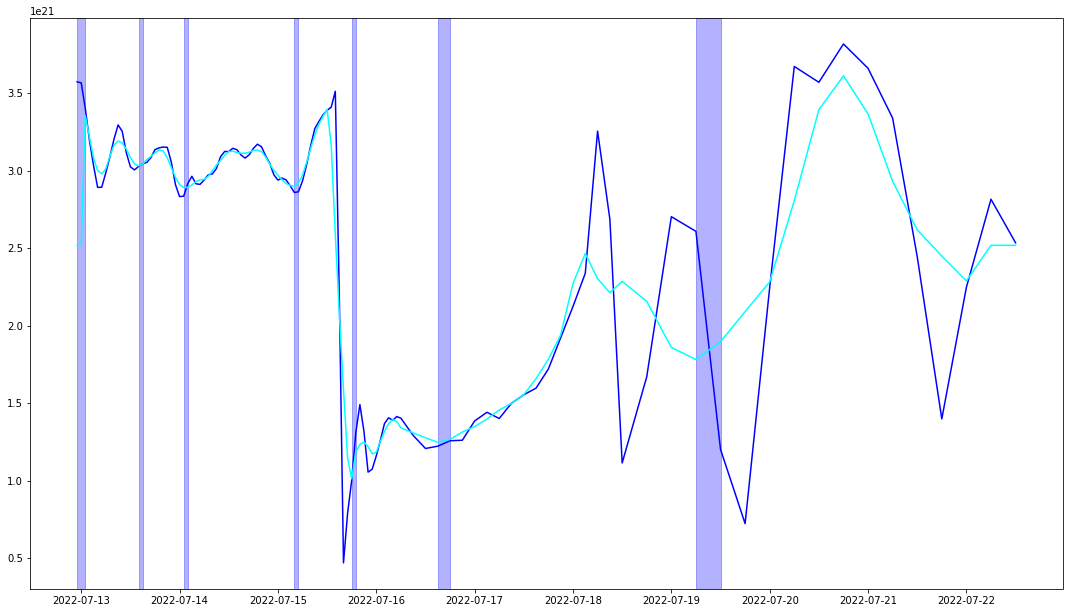

In [232]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

forecastPlot=forecast.iloc[2:]
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

forecastPlot= forecastPlot.reindex()

fig, ax = plt.subplots(figsize=(4, 4))

plt.plot(forecastPlot['date'],forecastPred,color = 'blue')
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan')

# highlight a time range

#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
while i < len(forecastPlot['date']):
    print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) < len(forecastPlot['date'])) and ( highlights[i]):
        if highlights[i+j]:
            j=j+1
        else:
            print("Plotting with i and j are given by",i,j)
            ax.axvspan(forecastPlot['date'][i],forecastPlot['date'][j+i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        

                


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)


In [ ]:
forecast=forecast.drop('date',1)
forecast=forecast.drop('dayInMonth',1)
forecast=forecast.drop('hour',1)
forecast=forecast.drop('dayOfWeek',1)
forecast=forecast.drop('dayOfYear',1)

In [ ]:
len(forecast.columns)

In [ ]:
tf_forecast=tf.convert_to_tensor(forecast)

In [ ]:
conv_model.predict(tf_forecast)

In [ ]:
[print(i.shape, i.dtype, i.name) for i in conv_model.inputs]
